<a href="https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/m1_project/Examples/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Pytorch

This notebook is also available for comment [on NB](http://nb.mit.edu/f/55895).

These have been adapted from [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In this notebook we'll be using the Caltech 256 dataset (which we've used for a bunch of the examples in this module) to show how we can adapt a pretrained model to a new dataset.

All of the pretrained models were trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) dataset.  Specifically, these networks were trained to recognize 1,000 different object classes.

[Transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) is a branch of machine learning that focuses on using knowledged acquired from one learning problem and applying it to another.  In the case of a neural network, what we'll wind up doing is modifying the network trained on ImageNet so that it can be used on the Caltech data.  Specifically, we'll be chopping off the last layer of the pretrained network and replacing it with a linear layer that produces the 257 numbers (there are 256 object classes in Caltech 256 and a "clutter" category) necessary for prediction in the Caltech 256 dataset.

Once we've modified our network, we can train it on the Caltech 256 Dataset.  The important caveat here is that we are going to freeze the weights for all but our newly added final layer.  This will allow the network to fairly rapidly converge to a decent solution.  You can also modify the code so that all weights in the network are trained and compare the results.

In [0]:
# standard importants for pytorch and torchvision
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
# We have created a precropped, resized version of Caltech 256
# The images are 224 by 224, which is a standard input size for models trained
# on ImageNet
import gdown
gdown.download('https://drive.google.com/uc?authuser=0&id=1ysiTEWE0ZAYPycw-Nt7zhd-pPKyUYSE1&export=download',
               'caltech_224_224.hdf5',
               quiet=False)

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1ysiTEWE0ZAYPycw-Nt7zhd-pPKyUYSE1&export=download
To: /content/caltech_224_224.hdf5
4.61GB [01:01, 74.4MB/s]


'caltech_224_224.hdf5'

In [0]:
import h5py
from torch.utils.data import Dataset
from torchvision import transforms
import PIL

# This is the class that we gave for wrapping an hdf5 file.  It is much faster
# than loading the images from JPGs every time.
class H5Dataset(Dataset):
    def __init__(self, h5_path, augment_data=False):
        super(H5Dataset, self).__init__()
        self.h5_file = h5py.File(h5_path, 'r', libver='latest', swmr=True)
        self.augment_data = augment_data
        # data augmentation is when you apply random transformations to your
        # training data in order to increase the generalizability of the learned
        # model and avoid overfitting

        # these are the transformations to apply if we are augmenting data
        self.augmentation_transformations = transforms.Compose([transforms.ToPILImage(),
                                                                transforms.ColorJitter(hue=.05, saturation=.05),
                                                                transforms.RandomHorizontalFlip(),
                                                                transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                                                                transforms.ToTensor(),
                                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # maybe try with no normalization
        # these are the transformations to apply if we are not augmenting data
        self.normal_transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.target_cache = []
        for i in range(len(self)):
            self.target_cache.append(self.h5_file['targets'][i])

    def __getitem__(self, index):
        if self.augment_data:
            return self.augmentation_transformations(self.h5_file['data'][index]), self.target_cache[index]
        else:
            return self.normal_transformations(self.h5_file['data'][index]), self.target_cache[index]

    def set_augmentation(self, augment_data):
        self.augment_data = augment_data

    def __len__(self):
        return len(self.h5_file['data'])

    def close_dataset(self):
        self.h5_file.close()

cal_tech = H5Dataset('caltech_224_224.hdf5', True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


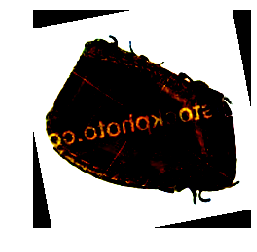

In [0]:
im, target = cal_tech[500]

plt.imshow(im.transpose(0,1).transpose(1,2))
plt.axis('off')
plt.show()

In [0]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

# Number of classes in the dataset
num_classes = 257

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        batch_num = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                # TODO: access this through dataloader somehow
                cal_tech.set_augmentation(True)
            else:
                model.eval()   # Set model to evaluate mode
                cal_tech.set_augmentation(False)


            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(phase, "processing batch", batch_num)
                batch_num += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].sampler)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
# this function freezes the weights of the network, unless we are not in
# feature extracting mode.  The last layer (the one we will train) is added
# after this function is called (so its weights will not be frozen)
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        # try a more complex final layer by uncommenting the following line
        # I (Paul) didn't adapt this to other network types, but you could
        #model_ft.fc = nn.Sequential(
        #        nn.Linear(num_ftrs, 512),
        #        nn.ReLU(),
        #        nn.Dropout(0.4),
        #        nn.Linear(512, 257)
        #)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold

# do stratified sampling
splitter = StratifiedKFold(n_splits=10, shuffle=True)
# trick sklearn to letting us do this without X values by passing None for the inputs
splitter.get_n_splits([None]*len(cal_tech), cal_tech.target_cache)
train_idx, test_idx = next(splitter.split([None]*len(cal_tech), cal_tech.target_cache))

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(cal_tech, batch_size=batch_size,
                                        sampler=train_sampler, num_workers=2)


test_loader = torch.utils.data.DataLoader(cal_tech, batch_size=batch_size,
                                        sampler=test_sampler, num_workers=2)

In [0]:
device = 'cuda'
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 classifier.weight
	 classifier.bias


In [0]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {'train': train_loader, 'val': test_loader}

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=500, is_inception=(model_name=="inception"))

Epoch 0/499
----------
train Loss: 2.2521 Acc: 0.5635
val Loss: 1.0137 Acc: 0.7698

Epoch 1/499
----------
train Loss: 0.9989 Acc: 0.7737
val Loss: 0.8713 Acc: 0.7874

Epoch 2/499
----------
train Loss: 0.8039 Acc: 0.8071
val Loss: 0.8339 Acc: 0.8079

Epoch 3/499
----------
train Loss: 0.6999 Acc: 0.8266
val Loss: 0.7836 Acc: 0.8025

Epoch 4/499
----------
train Loss: 0.6433 Acc: 0.8406
val Loss: 0.8242 Acc: 0.8085

Epoch 5/499
----------
train Loss: 0.5926 Acc: 0.8501
val Loss: 0.8279 Acc: 0.7984

Epoch 6/499
----------


KeyboardInterrupt: ignored

A thorough examination of doing transfer learning with [big convolutional neural network architectures on CalTech 256](https://github.com/TropComplique/image-classification-caltech-256).  This shows the results of a bunch of experiments.  The methods are a bit fancier than what we are doing here.  For instance, some of the layers farther down in the network are trained while some are held fixed.